In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import cvxopt
import pyreadr
import os
import time
from datetime import timedelta
from scipy.stats import norm
import copy
import warnings
import utils
import regression_fit
import pickle
from importlib import reload
reload(utils)
reload(regression_fit)
from utils import *
from regression_fit import *

home = os.getcwd()

## Dataset preprocessing
Train set: from 2014 to 2018. Test set: from 2019 to 2021

In [187]:
# Import dataset of group C
GroupC = pyreadr.read_r(home + '\\Other_data\\GroupC.rda')
GroupC_df = pd.DataFrame(list(GroupC.values())[0])

# Add lagged net-load values (columns y0_96, y0_336, diff_96, diff_336)
GroupC_df = add_autoregressive_features(GroupC_df)

# Split in train and test set 
train_set = GroupC_df[720:87440] 
test_set = GroupC_df[87440:]

## Persistence benchmark (7 days)

In [190]:
pb_reg = Persistence_Benchmark(GroupC_df)
y_pers_benchmark = pb_reg.predict(test_set['targetTime'],delay_days=7)

In [191]:
idx_2020 = 17516
idx_2021 = 35104

print("\nPersistence Benchmark (7 days)")

print("\nRMSE in 2019: ", RMSE(np.array(test_set['node'][:idx_2020]), y_pers_benchmark[:idx_2020]))
print("RMSE in 2020: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_pers_benchmark[idx_2020:idx_2021]))
print("RMSE in 2021: ", RMSE(np.array(test_set['node'][idx_2021:]), y_pers_benchmark[idx_2021:]))

print("\nMAE in 2019: ", MAE(np.array(test_set['node'][:idx_2020]), y_pers_benchmark[:idx_2020]))
print("MAE in 2020: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_pers_benchmark[idx_2020:idx_2021]))
print("MAE in 2021: ", MAE(np.array(test_set['node'][idx_2021:]), y_pers_benchmark[idx_2021:]))

print("\nMAPE in 2019: ", MAPE(np.array(test_set['node'][:idx_2020]), y_pers_benchmark[:idx_2020]))
print("MAPE in 2020: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_pers_benchmark[idx_2020:idx_2021]))
print("MAPE in 2021: ", MAPE(np.array(test_set['node'][idx_2021:]), y_pers_benchmark[idx_2021:]))


Persistence Benchmark (7 days)

RMSE in 2019:  100.81617543741869
RMSE in 2020:  103.70022511987322
RMSE in 2021:  95.73663911090364

MAE in 2019:  67.17743343229048
MAE in 2020:  62.15615504889698
MAE in 2021:  65.00065158486707

MAPE in 2019:  0.04257464721384691
MAPE in 2020:  0.04393787190774263
MAPE in 2021:  0.046327473105548134


## Persistence benchmark (2 days)

In [193]:
pb_reg = Persistence_Benchmark(GroupC_df)
y_pers_benchmark_2 = pb_reg.predict(test_set['targetTime'],delay_days=2)

In [194]:
print("\nPersistence Benchmark (2 days)")

print("\nRMSE in 2019: ", RMSE(np.array(test_set['node'][:idx_2020]), y_pers_benchmark_2[:idx_2020]))
print("RMSE in 2020: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_pers_benchmark_2[idx_2020:idx_2021]))
print("RMSE in 2021: ", RMSE(np.array(test_set['node'][idx_2021:]), y_pers_benchmark_2[idx_2021:]))

print("\nMAE in 2019: ", MAE(np.array(test_set['node'][:idx_2020]), y_pers_benchmark_2[:idx_2020]))
print("MAE in 2020: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_pers_benchmark_2[idx_2020:idx_2021]))
print("MAE in 2021: ", MAE(np.array(test_set['node'][idx_2021:]), y_pers_benchmark_2[idx_2021:]))

print("\nMAPE in 2019: ", MAPE(np.array(test_set['node'][:idx_2020]), y_pers_benchmark_2[:idx_2020]))
print("MAPE in 2020: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_pers_benchmark_2[idx_2020:idx_2021]))
print("MAPE in 2021: ", MAPE(np.array(test_set['node'][idx_2021:]), y_pers_benchmark_2[idx_2021:]))


Persistence Benchmark (2 days)

RMSE in 2019:  200.72941209736166
RMSE in 2020:  163.31341384324594
RMSE in 2021:  145.97276423389238

MAE in 2019:  142.163789963462
MAE in 2020:  107.93039003866272
MAE in 2021:  102.60333863752558

MAPE in 2019:  0.08965818547992463
MAPE in 2020:  0.07554642372525887
MAPE in 2021:  0.07415780793903812


## GAM-Point model 
Forecasts obtained in R with the bam function of the mgcv package

Target variable: Net-Load

In [196]:
y_R = pyreadr.read_r(home + '\\Other_data\\Results R\\GroupC_GAM_R_bam.rda')
y_R = pd.DataFrame(list(y_R.values())[0])
y_R_test_set = np.array(y_R).flatten()

In [197]:
print("GAM-Point model")
print("\nRMSE in 2019: ", RMSE(np.array(test_set['node'][:idx_2020]), y_R_test_set[:idx_2020]))
print("RMSE in 2020: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_R_test_set[idx_2020:idx_2021]))
print("RMSE in 2021: ", RMSE(np.array(test_set['node'][idx_2021:]), y_R_test_set[idx_2021:]))

print("\nMAE in 2019: ", MAE(np.array(test_set['node'][:idx_2020]), y_R_test_set[:idx_2020]))
print("MAE in 2020: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_R_test_set[idx_2020:idx_2021]))
print("MAE in 2021: ", MAE(np.array(test_set['node'][idx_2021:]), y_R_test_set[idx_2021:]))

print("\nMAPE in 2019: ", MAPE(np.array(test_set['node'][:idx_2020]), y_R_test_set[:idx_2020]))
print("MAPE in 2020: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_R_test_set[idx_2020:idx_2021]))
print("MAPE in 2021: ", MAPE(np.array(test_set['node'][idx_2021:]), y_R_test_set[idx_2021:]))

GAM-Point model

RMSE in 2019:  94.54239965684208
RMSE in 2020:  189.74627717636582
RMSE in 2021:  218.3937099422912

MAE in 2019:  67.29442619593189
MAE in 2020:  146.4255837322792
MAE in 2021:  190.38491270535533

MAPE in 2019:  0.0443348751046968
MAPE in 2020:  0.1075917548318627
MAPE in 2021:  0.13582287459904416


## Static Kalman GAM
Results obtained in R

In [199]:
GroupC_KF = pyreadr.read_r(home + '\\Other_data\\KF R\\GroupC_KF_static_delay.rda')
y_kf_static = pd.DataFrame(list(GroupC_KF.values())[0])
y_kf_static_delay_R = np.array(y_kf_static).flatten()

In [200]:
print("Static Kalman GAM")
print("\nRMSE in 2019: ", RMSE(np.array(test_set['node'][:idx_2020]), y_kf_static_delay_R[:idx_2020]))
print("RMSE in 2020: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_static_delay_R[idx_2020:idx_2021]))
print("RMSE in 2021: ", RMSE(np.array(test_set['node'][idx_2021:]), y_kf_static_delay_R[idx_2021:]))

print("\nMAE in 2019: ", MAE(np.array(test_set['node'][:idx_2020]), y_kf_static_delay_R[:idx_2020]))
print("MAE in 2020: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_static_delay_R[idx_2020:idx_2021]))
print("MAE in 2021: ", MAE(np.array(test_set['node'][idx_2021:]), y_kf_static_delay_R[idx_2021:]))

print("\nMAPE in 2019: ", MAPE(np.array(test_set['node'][:idx_2020]), y_kf_static_delay_R[:idx_2020]))
print("MAPE in 2020: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_static_delay_R[idx_2020:idx_2021]))
print("MAPE in 2021: ", MAPE(np.array(test_set['node'][idx_2021:]), y_kf_static_delay_R[idx_2021:]))

Static Kalman GAM

RMSE in 2019:  91.3114358282053
RMSE in 2020:  125.20872987910607
RMSE in 2021:  96.70014195832321

MAE in 2019:  63.593532458180896
MAE in 2020:  92.96308339947768
MAE in 2021:  79.78325737835146

MAPE in 2019:  0.04204334448237189
MAPE in 2020:  0.07206281283798316
MAPE in 2021:  0.06309646059623088


## Dynamic Kalman GAM 
Hyperparameters obtained with the Reduced Grid Search (I) method, which uses the Identity Initialization Matrix

In [202]:
GroupC_KF = pyreadr.read_r(home + '\\Other_data\\KF R\\GroupC_KF_dynamic_delay.rda')
y_kf_dynamic = pd.DataFrame(list(GroupC_KF.values())[0])
y_kf_dynamic_delay_R = np.array(y_kf_dynamic).flatten()

In [203]:
print("Dynamic Kalman GAM ")
print("\nRMSE in 2019: ", RMSE(np.array(test_set['node'][:idx_2020]), y_kf_dynamic_delay_R[:idx_2020]))
print("RMSE in 2020: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_dynamic_delay_R[idx_2020:idx_2021]))
print("RMSE in 2021: ", RMSE(np.array(test_set['node'][idx_2021:]), y_kf_dynamic_delay_R[idx_2021:]))

print("\nMAE in 2019: ", MAE(np.array(test_set['node'][:idx_2020]), y_kf_dynamic_delay_R[:idx_2020]))
print("MAE in 2020: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_dynamic_delay_R[idx_2020:idx_2021]))
print("MAE in 2021: ", MAE(np.array(test_set['node'][idx_2021:]), y_kf_dynamic_delay_R[idx_2021:]))

print("\nMAPE in 2019: ", MAPE(np.array(test_set['node'][:idx_2020]), y_kf_dynamic_delay_R[:idx_2020]))
print("MAPE in 2020: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_dynamic_delay_R[idx_2020:idx_2021]))
print("MAPE in 2021: ", MAPE(np.array(test_set['node'][idx_2021:]), y_kf_dynamic_delay_R[idx_2021:]))

Dynamic Kalman GAM 

RMSE in 2019:  86.69105871716577
RMSE in 2020:  102.37331768470794
RMSE in 2021:  70.54845183037716

MAE in 2019:  58.78189186343761
MAE in 2020:  75.70152181859002
MAE in 2021:  53.91522322469031

MAPE in 2019:  0.038914434858764814
MAPE in 2020:  0.05836606441652061
MAPE in 2021:  0.04021341279497603


# LM-Point model
Linear Regression model 

Response variable: 7-days differenced net-load

In [205]:
St_train = regression_feature_matrix(train_set)

# Target variable is the 7-days differenced net-load
model = sm.OLS(train_set["diff_336"], St_train)
results = model.fit()             
params = results.params

St_test = regression_feature_matrix(test_set)

# The net-load value of 7 days prior is added back to the differenced net-load forecast 
y_lin = np.array(test_set['y0_336']) + St_test@params

In [206]:
idx_2020 = 17516 #Index of the first data point in 2020
idx_2021 = 35104 #Index of the first data point in 2021

print("LM-Point model")

print("\nRMSE in 2019 test set: ", RMSE(np.array(test_set['node'][:idx_2020]), y_lin[:idx_2020]))
print("RMSE in 2020 test set: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_lin[idx_2020:idx_2021]))
print("RMSE in 2021 test set: ", RMSE(np.array(test_set['node'][idx_2021:]), y_lin[idx_2021:]))

print("\nMAE in 2019 test set: ", MAE(np.array(test_set['node'][:idx_2020]), y_lin[:idx_2020]))
print("MAE in 2020 test set: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_lin[idx_2020:idx_2021]))
print("MAE in 2021 test set: ", MAE(np.array(test_set['node'][idx_2021:]), y_lin[idx_2021:]))

print("\nMAPE in 2019 test set: ", MAPE(np.array(test_set['node'][:idx_2020]), y_lin[:idx_2020]))
print("MAPE in 2020 test set: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_lin[idx_2020:idx_2021]))
print("MAPE in 2021 test set: ", MAPE(np.array(test_set['node'][idx_2021:]), y_lin[idx_2021:]))

LM-Point model

RMSE in 2019 test set:  63.36064826537353
RMSE in 2020 test set:  91.28005804352495
RMSE in 2021 test set:  70.6108941949944

MAE in 2019 test set:  43.40790408204027
MAE in 2020 test set:  66.92373759146034
MAE in 2021 test set:  53.14419971601172

MAPE in 2019 test set:  0.02846208445059237
MAPE in 2020 test set:  0.04968013506212864
MAPE in 2021 test set:  0.03813450326223594


# Static Kalman LM

In [208]:
kf_static_OLS = Kalman_Filter(GAM=False,params=params)
kf_static_OLS.fit(St_train, train_set['diff_336'])
# Computation of the standard deviation of the components of the state vector (required for the Reduced Grid Search (II) method)
std_static_OLS = np.std(kf_static_OLS.theta_mat[15000:],axis=0)

St_test = regression_feature_matrix(test_set)
y_static_mean, _ = kf_static_OLS.predict(St_test, test_set[["targetTime", "diff_336"]], delay=True) 

# The net-load value of 7 days prior is added back to the differenced net-load forecast 
y_static_mean += test_set["y0_336"]

In [209]:
print("Static Kalman GAM")

print("\nRMSE in 2019: ", RMSE(np.array(test_set['node'][:idx_2020]), y_static_mean[:idx_2020]))
print("RMSE in 2020: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_static_mean[idx_2020:idx_2021]))
print("RMSE in 2021: ", RMSE(np.array(test_set['node'][idx_2021:]), y_static_mean[idx_2021:]))

print("\nMAE in 2019: ", MAE(np.array(test_set['node'][:idx_2020]), y_static_mean[:idx_2020]))
print("MAE in 2020: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_static_mean[idx_2020:idx_2021]))
print("MAE in 2021: ", MAE(np.array(test_set['node'][idx_2021:]), y_static_mean[idx_2021:]))

print("\nMAPE in 2019: ", MAPE(np.array(test_set['node'][:idx_2020]), y_static_mean[:idx_2020]))
print("MAPE in 2020: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_static_mean[idx_2020:idx_2021]))
print("MAPE in 2021: ", MAPE(np.array(test_set['node'][idx_2021:]), y_static_mean[idx_2021:]))

Static Kalman GAM

RMSE in 2019:  62.12951261715836
RMSE in 2020:  82.03365062324565
RMSE in 2021:  55.61336194089014

MAE in 2019:  41.79252117512344
MAE in 2020:  55.66674271809535
MAE in 2021:  41.37793816359554

MAPE in 2019:  0.02728621625460565
MAPE in 2020:  0.04163105038589581
MAPE in 2021:  0.030659077623048103


# Dynamic Kalman LM

Hyperparameters optimization with the Reduced Grid Search (II) method, which uses the State Variance Optimization method 


In [212]:
q_list = [1e-10,1e-11, 1e-12, 1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18, 1e-19]
optim = Q_optimization(St_train, train_set[["targetTime", "diff_336"]],GAM=False,params=params)
Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list, std_static=std_static_OLS) 

1e-10
-997775.507024376
1e-11
-1175586.0577433319
1e-12
-1091306.8627075683
1e-13
-496608.66687429027
1e-14
-490705.86762752465
1e-15
-613559.6433364035
1e-16
-490994.0024880363
1e-17
-491951.2542055932
1e-18
-491895.0138056011
1e-19
-491877.45542190556
Optimal q:  4.25826489462451e-11
Optimal sigma:  65.25538211231706
Maximum likelihood achieved:  -490705.86762752465


In [213]:
kf_dynamic_OLS = Kalman_Filter(GAM=False, Q=Q, sigma=sigma, P=P, theta1=theta1, params=params)
kf_dynamic_OLS.fit(St_train, train_set['diff_336'])

St_test = regression_feature_matrix(test_set)

y_dynamic_mean, _ = kf_dynamic_OLS.predict(St_test, test_set[["targetTime", "diff_336"]], delay=True)

# The net-load value of 7 days prior is added back to the differenced net-load forecast 
y_dynamic_mean += test_set["y0_336"]

In [214]:
print("Dynamic Kalman LM")

print("\nRMSE in 2019: ", RMSE(np.array(test_set['node'][:idx_2020]), y_dynamic_mean[:idx_2020]))
print("RMSE in 2020: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_dynamic_mean[idx_2020:idx_2021]))
print("RMSE in 2021: ", RMSE(np.array(test_set['node'][idx_2021:]), y_dynamic_mean[idx_2021:]))

print("\nMAE in 2019: ", MAE(np.array(test_set['node'][:idx_2020]), y_dynamic_mean[:idx_2020]))
print("MAE in 2020: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_dynamic_mean[idx_2020:idx_2021]))
print("MAE in 2021: ", MAE(np.array(test_set['node'][idx_2021:]), y_dynamic_mean[idx_2021:]))

print("\nMAPE in 2019: ", MAPE(np.array(test_set['node'][:idx_2020]), y_dynamic_mean[:idx_2020]))
print("MAPE in 2020: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_dynamic_mean[idx_2020:idx_2021]))
print("MAPE in 2021: ", MAPE(np.array(test_set['node'][idx_2021:]), y_dynamic_mean[idx_2021:]))

Dynamic Kalman LM

RMSE in 2019:  59.120459539829504
RMSE in 2020:  73.37119657380016
RMSE in 2021:  51.1623999051792

MAE in 2019:  38.96966196790629
MAE in 2020:  48.69054313949033
MAE in 2021:  39.045605203679315

MAPE in 2019:  0.025624797699290398
MAPE in 2020:  0.03695830483718879
MAPE in 2021:  0.029548353771983824


## Comparison among target variables for Dynamic Kalman GAM by using Iterative Grid Search

### Target variable: Normalized net-load

List: [1, 2^-1, 2^-2, 2^-3, 2^-4, 2^-5, 2^-6, 2^-7, 2^-8, 2^-9, 2^-10, 
         2^-11, 2^-12, 2^-13, 2^-14, 2^-15, 2^-16, 2^-17, 2^-18, 2^-19,2^-20, 
         2^-21, 2^-22, 2^-23, 2^-24, 2^-25, 2^-26, 2^-27, 2^-28, 2^-29,2^-30]

In [217]:
GroupC_KF = pyreadr.read_r(home + '\\Other_data\\KF R\\GroupC_KF_dynamic_delay_node_n.rda')
y_kf_dynamic = pd.DataFrame(list(GroupC_KF.values())[0])
y_kf_dynamic_delay_R_n = np.array(y_kf_dynamic).flatten()

In [218]:
print("Dynamic Kalman GAM - Normalized net-load")
print("\nRMSE in 2019: ", RMSE(np.array(test_set['node'][:idx_2020]), y_kf_dynamic_delay_R_n[:idx_2020]))
print("RMSE in 2020: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_dynamic_delay_R_n[idx_2020:idx_2021]))
print("RMSE in 2021: ", RMSE(np.array(test_set['node'][idx_2021:]), y_kf_dynamic_delay_R_n[idx_2021:]))

print("\nMAE in 2019: ", MAE(np.array(test_set['node'][:idx_2020]), y_kf_dynamic_delay_R_n[:idx_2020]))
print("MAE in 2020: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_dynamic_delay_R_n[idx_2020:idx_2021]))
print("MAE in 2021: ", MAE(np.array(test_set['node'][idx_2021:]), y_kf_dynamic_delay_R_n[idx_2021:]))

print("\nMAPE in 2019: ", MAPE(np.array(test_set['node'][:idx_2020]), y_kf_dynamic_delay_R_n[:idx_2020]))
print("MAPE in 2020: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_dynamic_delay_R_n[idx_2020:idx_2021]))
print("MAPE in 2021: ", MAPE(np.array(test_set['node'][idx_2021:]), y_kf_dynamic_delay_R_n[idx_2021:]))

Dynamic Kalman GAM - Normalized net-load

RMSE in 2019:  121.08651944064846
RMSE in 2020:  136.56534740774535
RMSE in 2021:  94.9943748707567

MAE in 2019:  96.63066816099463
MAE in 2020:  106.974935813577
MAE in 2021:  76.88694306463924

MAPE in 2019:  0.06709383677812038
MAPE in 2020:  0.08329245065458167
MAPE in 2021:  0.059393031889280676


### Target variable: Net-load

List: [2^-15,2^-20,2^-25,2^-28,2^-30,2^-32,2^-34,2^-36,2^-38,2^-40,2^-45,2^-50]

In [220]:
GroupC_KF = pyreadr.read_r(home + '\\Other_data\\KF R\\GroupC_KF_dynamic_delay_node.rda')
y_kf_dynamic = pd.DataFrame(list(GroupC_KF.values())[0])
y_kf_dynamic_delay_R = np.array(y_kf_dynamic).flatten()

In [221]:
print("Dynamic Kalman GAM - Net-load")
print("\nRMSE in 2019 test set: ", RMSE(np.array(test_set['node'][:idx_2020]), y_kf_dynamic_delay_R[:idx_2020]))
print("RMSE in 2020 test set: ", RMSE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_dynamic_delay_R[idx_2020:idx_2021]))
print("RMSE in 2021 test set: ", RMSE(np.array(test_set['node'][idx_2021:]), y_kf_dynamic_delay_R[idx_2021:]))

print("\nMAE in 2019 test set: ", MAE(np.array(test_set['node'][:idx_2020]), y_kf_dynamic_delay_R[:idx_2020]))
print("MAE in 2020 test set: ", MAE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_dynamic_delay_R[idx_2020:idx_2021]))
print("MAE in 2021 test set: ", MAE(np.array(test_set['node'][idx_2021:]), y_kf_dynamic_delay_R[idx_2021:]))

print("\nMAPE in 2019 test set: ", MAPE(np.array(test_set['node'][:idx_2020]), y_kf_dynamic_delay_R[:idx_2020]))
print("MAPE in 2020 test set: ", MAPE(np.array(test_set['node'][idx_2020:idx_2021]), y_kf_dynamic_delay_R[idx_2020:idx_2021]))
print("MAPE in 2021 test set: ", MAPE(np.array(test_set['node'][idx_2021:]), y_kf_dynamic_delay_R[idx_2021:]))

Dynamic Kalman GAM - Net-load

RMSE in 2019 test set:  85.94806739676127
RMSE in 2020 test set:  97.10461083991673
RMSE in 2021 test set:  73.03084477325363

MAE in 2019 test set:  59.089399837127864
MAE in 2020 test set:  69.75705024499032
MAE in 2021 test set:  55.72733498514375

MAPE in 2019 test set:  0.03934119191335679
MAPE in 2020 test set:  0.052324972648997665
MAPE in 2021 test set:  0.041675267745833335


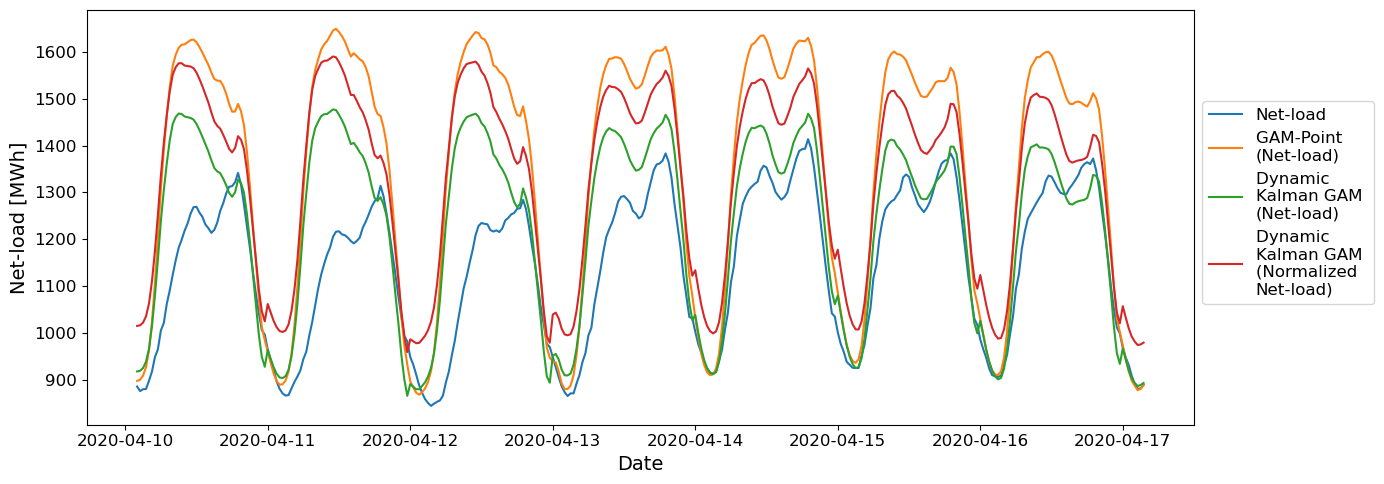

In [222]:
l=22320
j=22660

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(1,1,figsize=(14,5))
plt.plot(test_set['targetTime'][l:j], test_set['node'][l:j], label='Net-load')
plt.plot(test_set['targetTime'][l:j], y_R_test_set[l:j], label='GAM-Point \n(Net-load)')
plt.plot(test_set['targetTime'][l:j], y_kf_dynamic_delay_R[l:j], label='Dynamic \nKalman GAM \n(Net-load)')
plt.plot(test_set['targetTime'][l:j], y_kf_dynamic_delay_R_n[l:j], label='Dynamic \nKalman GAM \n(Normalized \nNet-load)')
plt.legend(loc='best', bbox_to_anchor=(1, 0.8));
plt.xlabel("Date", fontsize=14);
plt.ylabel("Net-load [MWh]", fontsize=14);
fig.tight_layout()
fig.savefig("Figures/grafici.jpg")

# Kalman LM Dynamic - Likelihood comparison 

### Hyperparameter Selection - Reduced Likelihood (I)

In [225]:
q_list = [1e-10,1e-11, 1e-12, 1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18,1e-19]

optim = Q_optimization(St_train, train_set[["targetTime", "diff_336"]],GAM=False,params=params)
Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list) 

1e-10
-911069.1987441413
1e-11
-875389.3830066116
1e-12
-880290.757273047
1e-13
-878352.5826203218
1e-14
-872028.389322069
1e-15
-867287.0445701776
1e-16
-852014.2749648364
1e-17
-1698256.0355191668
1e-18
-1570033.963532334
1e-19
-716604.5090957643
Optimal q:  2.0810410823140658e-17
Optimal sigma:  14.425813953860857
Maximum likelihood achieved:  -716604.5090957643


### Hyperparameter selection - Reduced Likelihood (II)

In [227]:
q_list = [1e-10,1e-11, 1e-12, 1e-13,1e-14,1e-15,1e-16, 1e-17, 1e-18,1e-19]

optim = Q_optimization(St_train, train_set[["targetTime", "diff_336"]],GAM=False,params=params)
Q, sigma, P, theta1 = optim.grid_search_reduced_likelihood(q_list=q_list, std_static=std_static_OLS) 

1e-10
-997775.507024376
1e-11
-1175586.0577433319
1e-12
-1091306.8627075683
1e-13
-496608.66687429027
1e-14
-490705.86762752465
1e-15
-613559.6433364035
1e-16
-490994.0024880363
1e-17
-491951.2542055932
1e-18
-491895.0138056011
1e-19
-491877.45542190556
Optimal q:  4.25826489462451e-11
Optimal sigma:  65.25538211231706
Maximum likelihood achieved:  -490705.86762752465
